In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
import torch.nn.functional as F
torch.set_float32_matmul_precision('medium')

# Exercise 3

Use POU-Net with neural operators to fit the following functional data. Working in the unit circle domain, $\Omega = \{x \in \mathbb{R}^2 : x\leq 1\}$, the true operator maps functions on $\Omega$ to functions on $\Omega$ where the both the input and output functions vanish at the boundaries of the domain. This situation is common when trying to model physical systems, e.g., the flow at the blade of a wind turbine can be assumed to be zero, but the flow elsewhere needs to be modeled. We call the details of the field behavior at the boundaries the boundary conditions.

We'll be working with an operator learning method we developed called MOR-Physics. See https://arxiv.org/pdf/1810.08552 and https://www.sciencedirect.com/science/article/pii/S004578252030685X. It's very similar to FNO. Try implementing it as described in the papers. The formula for the action of the parameterized operator is,
$$
\mathcal{N}(u) = \mathcal{F^{-1}}\left(g(\mathbf{\kappa}) \mathcal{F} (h(u)) \right)
$$
where $\mathcal{F}$ is the fourier transform, $g$ is a complex valued function of the wave vector $\kappa$, and $h$ is a point-wise nonlinearity.

Since the method is Fourier based, it only works for periodic domains, while the domain for the data is the unit circle. We can still work on the periodic domain and use MOR-Physics by embedding the circle inside a periodic domain and and use mixture of experts to fit the operator in the domain while mapping the region outside the domain to zero. See this paper for more details and generalizations of this approach in the context of numerical methods for solving PDEs, https://www.sciencedirect.com/science/article/pii/S0021999114000151

Try using MOR-physics to fit the operator in the unit circle while having it vanish outside. There's a few different levels of complexity you could try here. You could start off by fixing the POU's to be the unit circle and the region outside the circle and also fix the experts to be MOR-Physics inside the circle and the zero operator outside. Next you could try letting the POU's adopt to the domain and/or choosing between several MOR-Physics experts.

In [2]:
import tensorflow as tf

class sythnetic_data_op_gen:
    def __init__(self):
        n = 32
        L = 2.5
        x = np.arange(-n//2,n//2)/n*L
        y = np.arange(-n//2,n//2)/n*L
        
        X = np.stack(np.meshgrid(x,y,indexing='ij'),(-1))
        Xh = np.reshape(X,(-1,2))
        self.X = X
        self.Xh = Xh
        
        Xi = X[X[...,0]**2+X[...,1]**2<1]
        Xb = X[X[...,0]**2+X[...,1]**2>=1]
        
        def K(X1,X2,a=1.,l=3e-1):
            X1shape = X1.shape
            X2shape = X2.shape
            for _ in range(len(X2shape)-1):
                X1 = X1[...,None,:]
            for _ in range(len(X1shape)-1):
                X2 = X2[None]
            d2 = tf.reduce_sum((X1-X2)**2,-1)
            return (a*tf.exp(-d2/l**2))
        
        kbb = K(Xb,Xb)
        kib = K(Xh,Xb)
        kii = K(Xh,Xh)
        
        cov = kii-np.einsum('ij,jk',kib,tf.linalg.solve(kbb,tf.transpose(kib)))
        
        self.ksq = np.linalg.cholesky(cov+1e-4*np.eye(len(Xh)))
    def true_operator(self,u):
        u2 = u**2
        return np.roll(u2,1,axis=0) + np.roll(u2,-1,axis=0) + np.roll(u2,1,axis=1) + np.roll(u2,-1,axis=1) - 4*u2
    def sample_u(self):
        u = tf.reshape(np.dot(self.ksq,np.random.normal(0,1,len(self.Xh))),(32,32)).numpy()
        u[self.X[...,0]**2+self.X[...,1]**2>=1]=0
        return u
    def sample(self,N):
        us = [self.sample_u() for _ in range(N)]
        vs = [self.true_operator(u) for u in us]
        return self.X,np.stack(us,axis=0),np.stack(vs,axis=0)

gen = sythnetic_data_op_gen()

2024-10-25 20:29:19.300435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 20:29:29.605068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 20:29:29.638707: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
# this generates the training set. X contains the grid of (x,y) points. u_train is the input functions
# v_train is the output functions.

#X,u_train,v_train = gen.sample(10000)
#np.save('data/u_train2.npy', u_train)
#np.save('data/v_train2.npy', v_train)

In [4]:
import numpy as np
u_train = np.load('data/u_train2.npy')
v_train = np.load('data/v_train2.npy')

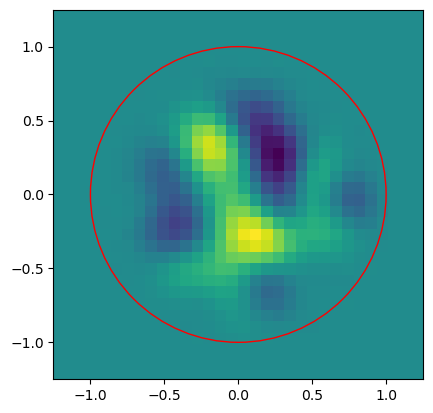

In [5]:
# this plots a sample of the input functions. Note the domain boundary in red
fig,ax = plt.subplots(1,1)
plt.imshow(u_train[5],extent=[-1.25,1.25,-1.25,1.25])
ax.add_patch(plt.Circle((0, 0), 1, ec='r',fc=[0,0,0,0]))

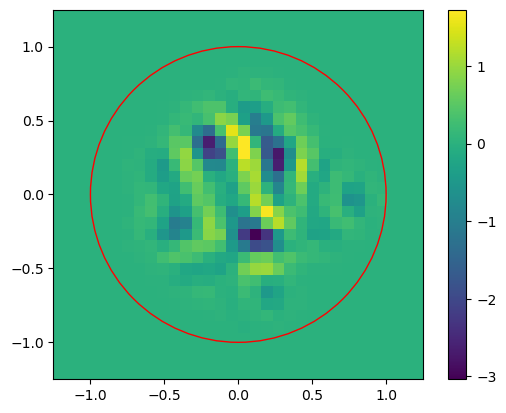

In [6]:
# this plots a sample of the output functions. Note the domain boundary in red
fig,ax = plt.subplots(1,1)
plt.imshow(v_train[5],extent=[-1.25,1.25,-1.25,1.25])
plt.colorbar()
ax.add_patch(plt.Circle((0, 0), 1, ec='r',fc=[0,0,0,0]))

In [7]:
from lightning_utils import *
from MOR_Operator import MOR_Operator
from POU_net import POU_net, PPOU_net

In [8]:
batch_size = 128

u_train = torch.as_tensor(u_train).float()
v_train = torch.as_tensor(v_train).float()
dataset = torch.utils.data.TensorDataset(u_train[:,None], v_train[:,None])
train, val = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size)

In [9]:
print(f'{u_train.shape=}')
print(f'{len(val_loader)=}')

u_train.shape=torch.Size([10000, 32, 32])
len(val_loader)=16


X.shape=torch.Size([128, 1, 32, 32]), y.shape=torch.Size([128, 1, 32, 32])
id=80


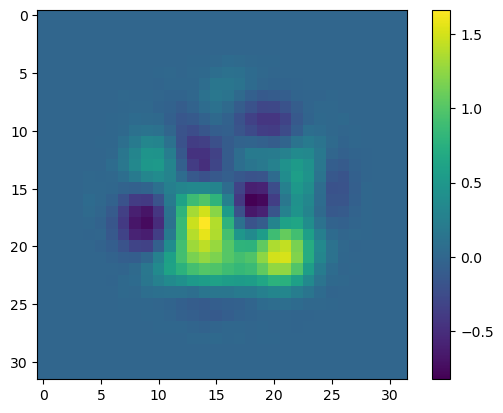

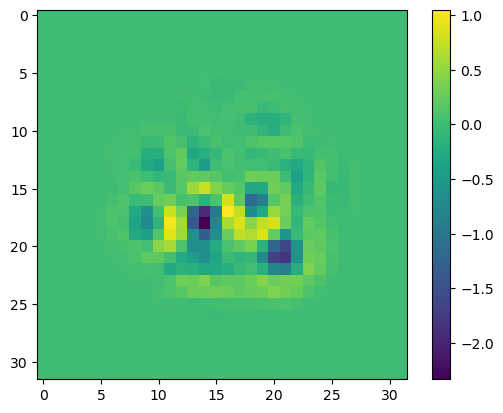

In [10]:
import random
X, y = next(iter(train_loader))
print(f'{X.shape=}, {y.shape=}')

i = random.randrange(len(X))
print(f'id={i}')

plt.figure(1)
plt.imshow(X[i].squeeze())
plt.colorbar()
plt.figure(2)
plt.imshow(y[i].squeeze())
plt.colorbar()
plt.show()

In [11]:
%pdb

Automatic pdb calling has been turned ON


In [45]:
torch.use_deterministic_algorithms(False)
L.seed_everything(0)

# train model
model = POU_net(1, 1, n_experts=2, lr=0.002, RLoP=False, T_max=10, k_modes=32, mlp_second=False, trig_encodings=True)
trainer = L.Trainer(max_epochs=500, accelerator='gpu', devices=1) #devices=3, strategy="ddp_notebook")
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
model = model.to('cuda:0')

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loading `train_dataloader` to estimate number of stepping batches.
/home/dsdeigh/miniforge3/envs/uqops+proxy/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.

  | Name          | Type           | Params | Mode 
---------------------------------------------------------
0 | gating_net    | FieldGatingNet | 2.4 K  | train
1 | experts       | ModuleList     | 4.6 M  | train
2 | train_metrics | MetricsModule  | 0      | train
3 | val_metrics   | MetricsModule  | 0      | train
---------------------------------------------------------
4.6 M     Trainable params
0        

estimated total steps:  31000


Sanity Checking: |                                                                                            …

/home/dsdeigh/miniforge3/envs/uqops+proxy/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=500` reached.


$$\text{(Scalar) }NLL_{i}=(\mu_i-y_i)^2/(2\sigma_i^2)+ln(\sigma_i)$$

### The 2nd Phase is Very Important!
Despite the exponential decay, I'm not entirely sure why (because I've verified again that L2 decay works).
But at least part of the reason is because it restarts the learning rate schedulers and the Adam adaptive learning rates too.

In [24]:
trainer = L.Trainer(max_epochs=5000, accelerator='gpu', devices=1)
trainer.fit(model=model, train_dataloaders=train_loader)
model = model.to('cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dsdeigh/miniforge3/envs/uqops+proxy/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
Loading `train_dataloader` to estimate number of stepping batches.
/home/dsdeigh/miniforge3/envs/uqops+proxy/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.

  | Name          | Type           | Params | Mode 
---------------------------------------------------------
0 | gating_net    | FieldGatingNet | 2.3 K  | train
1 | experts       | ModuleList     | 4.6 M  | train
2 |

estimated total steps:  310000


Training: |                                                                                                   …

/home/dsdeigh/miniforge3/envs/uqops+proxy/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
%pdb

In [12]:
trainer.validate(model, dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric         1.1417691894166637e-06
         val_R^2            0.9999918937683105
 val_explained_variance     0.9999918937683105
        val_loss          1.1417691894166637e-06
        val_sMAPE            0.636415421962738
        val_wMAPE          0.004099659156054258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.1417691894166637e-06,
  'val_R^2': 0.9999918937683105,
  'val_explained_variance': 0.9999918937683105,
  'val_wMAPE': 0.004099659156054258,
  'val_sMAPE': 0.636415421962738,
  'hp_metric': 1.1417691894166637e-06}]

## Expert Partitions:

In [39]:
gating_weights, topk = model.gating_net(X[0])
topk_sort_idx = torch.argsort(topk)
gating_weights, topk = gating_weights[:,topk_sort_idx], topk[topk_sort_idx]
print(f'{gating_weights.shape=}')

gating_weights.shape=torch.Size([1, 2, 32, 32])


In [40]:
ones = torch.ones(1,1,32,32, dtype=gating_weights.dtype, device=gating_weights.device)
zero_weight = ones - gating_weights.sum(axis=1)
experts_list = [zero_weight,  gating_weights]
if gating_weights.shape[1]==1:
    print('padding')
    experts_list.append(ones*0)
gating_weights = torch.cat(experts_list, axis=1)
print(f'{gating_weights.shape=}')

gating_weights.shape=torch.Size([1, 3, 32, 32])


In [41]:
torch.vmap(torch.mean)(gating_weights.squeeze())

tensor([0.3333, 0.3333, 0.3333], device='cuda:0', grad_fn=<MeanBackward1>)

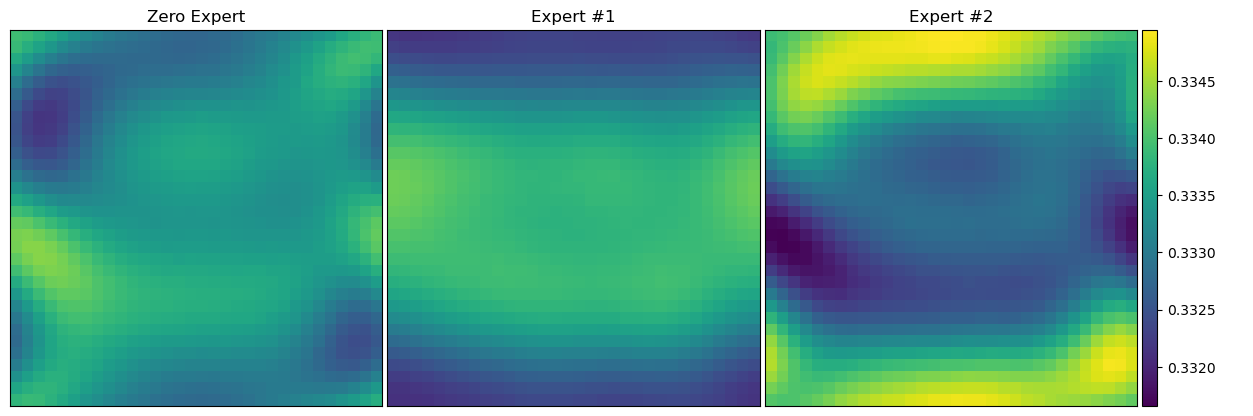

In [42]:
from grid_figures import GridFigure
GridFigure.compare_img_seq(list(gating_weights.squeeze().detach().cpu()), x_titles=['Zero Expert', 'Expert #1', 'Expert #2'])

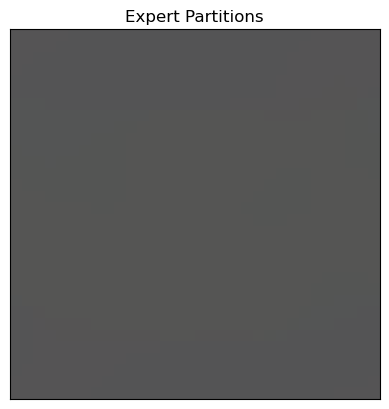

In [43]:
gating_weights_plt = gating_weights.squeeze().detach().cpu().moveaxis(0,-1).numpy()
plt.imshow(gating_weights_plt)
plt.title('Expert Partitions')
plt.xticks([],[])
plt.yticks([],[])
plt.show()

## View Predictions

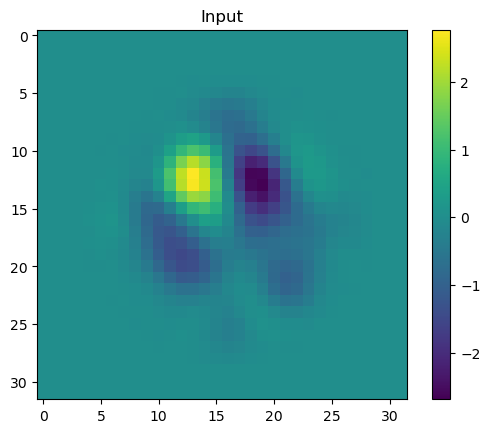

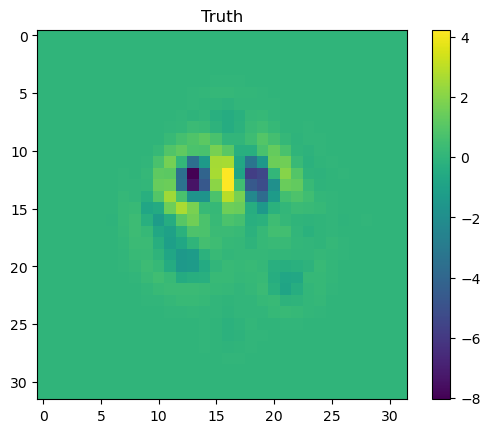

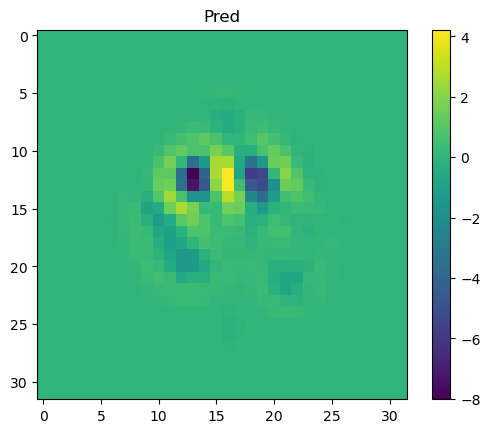

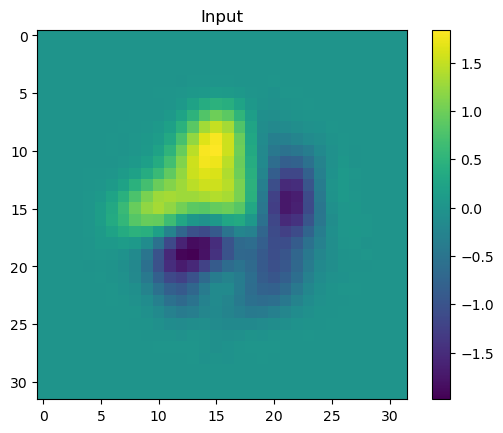

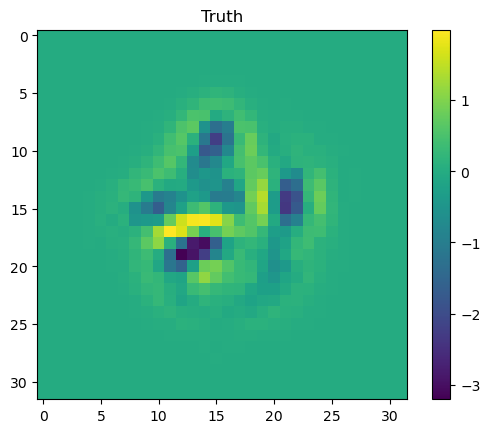

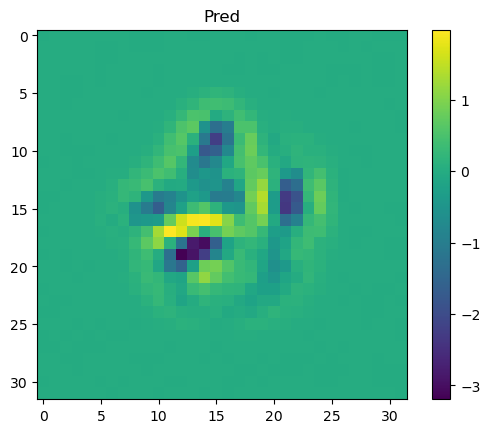

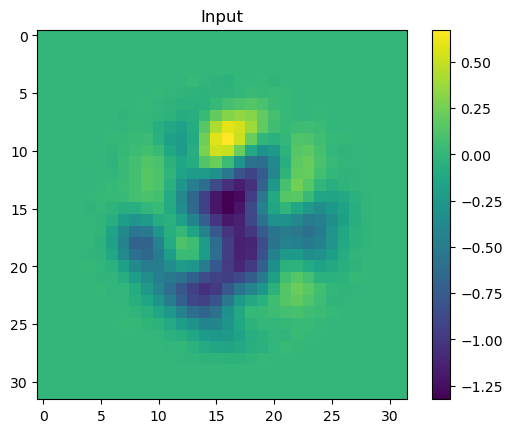

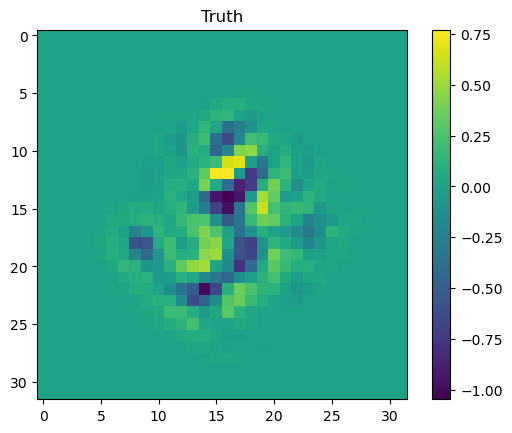

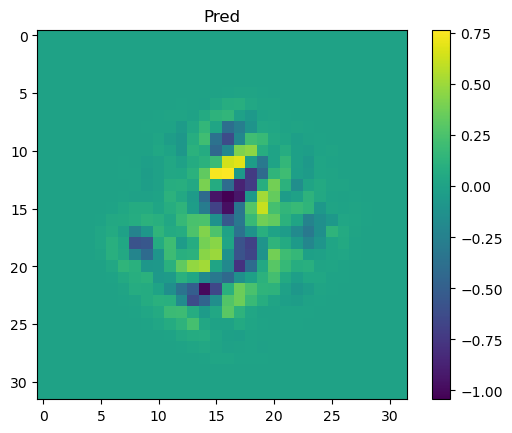

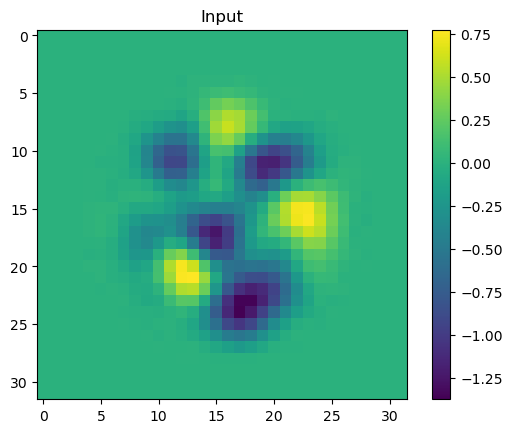

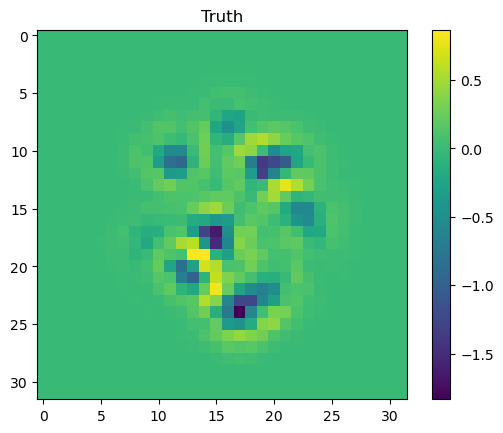

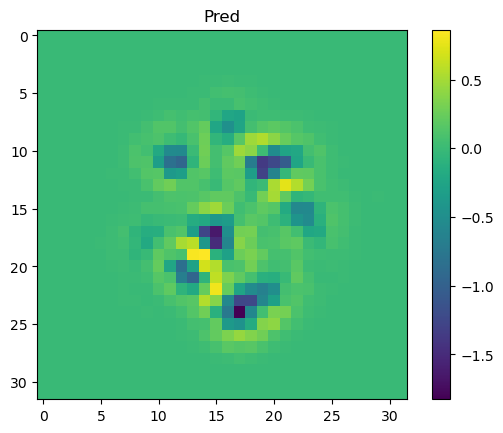

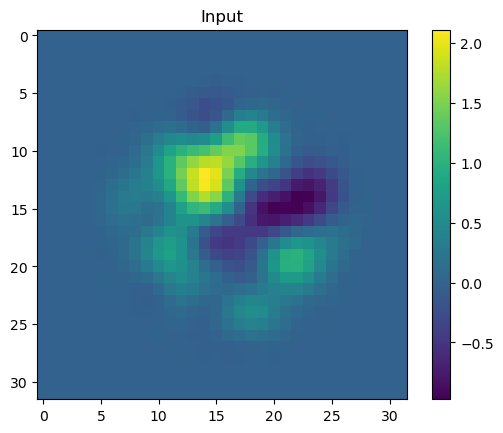

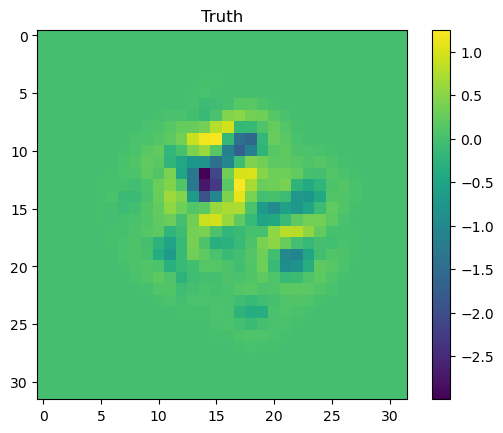

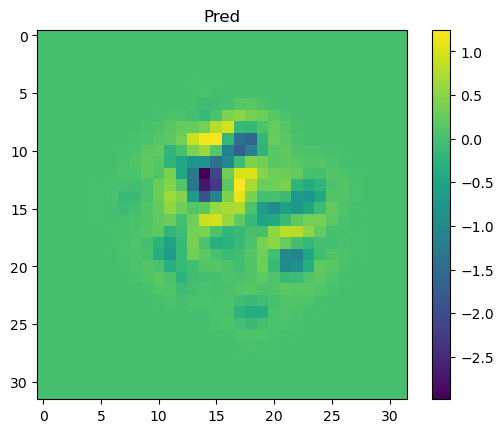

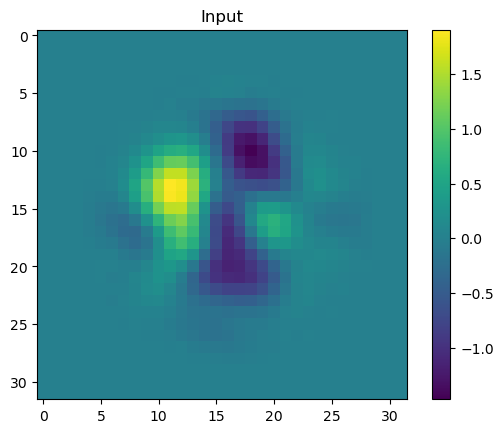

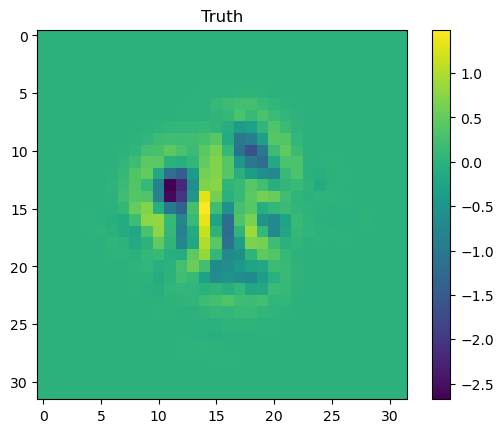

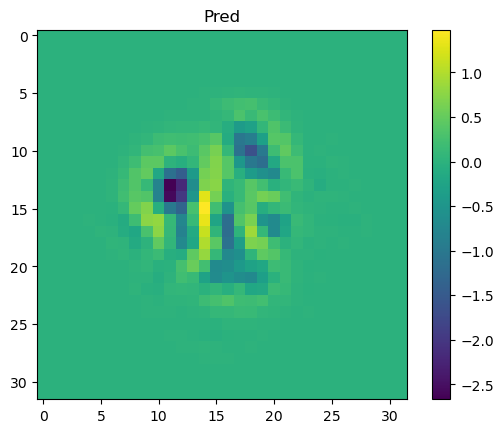

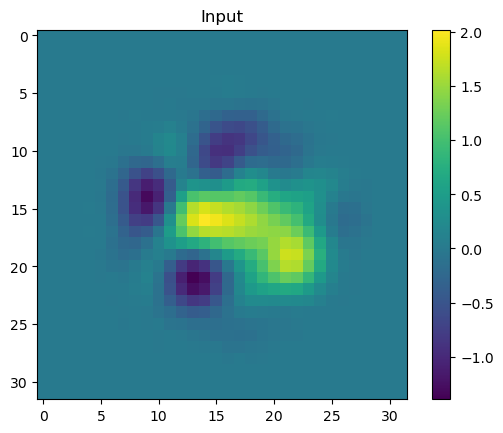

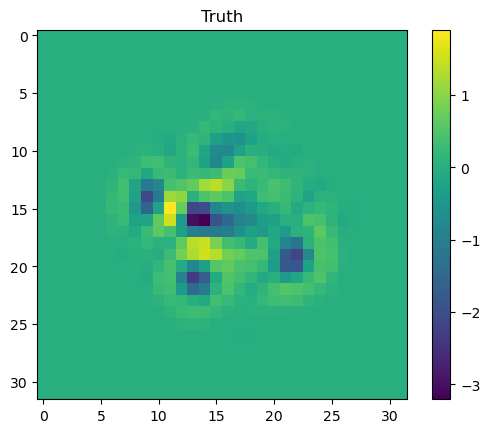

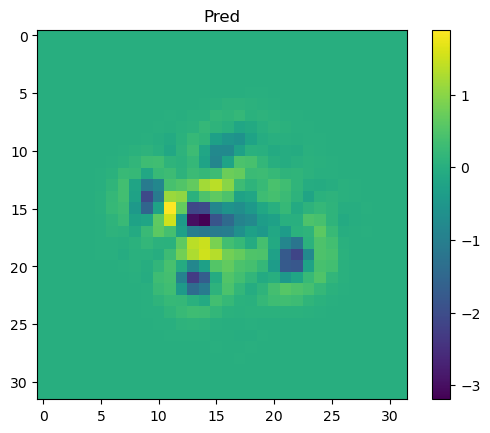

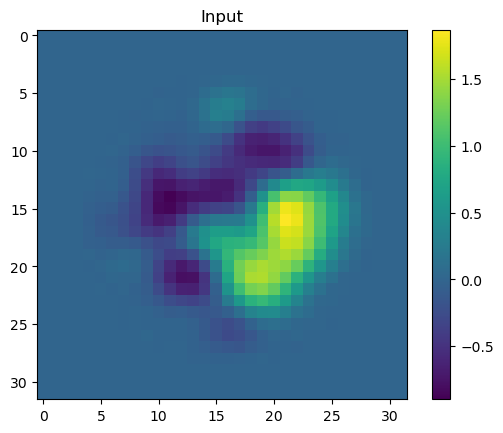

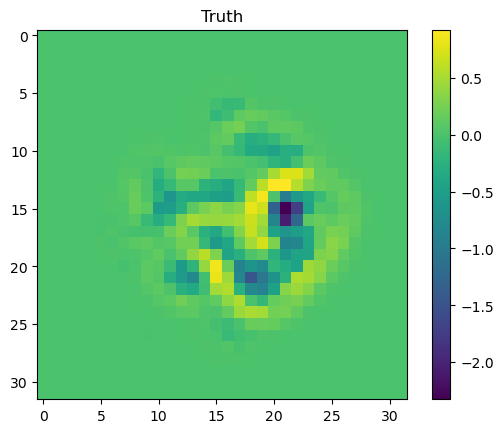

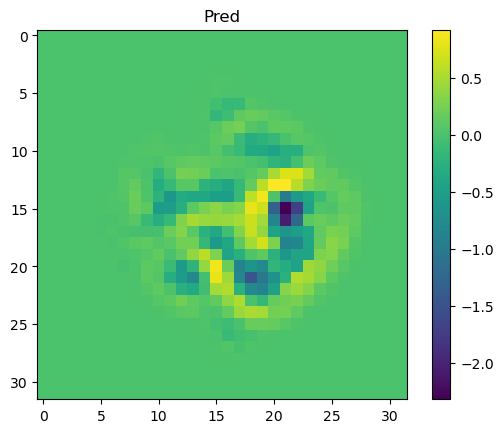

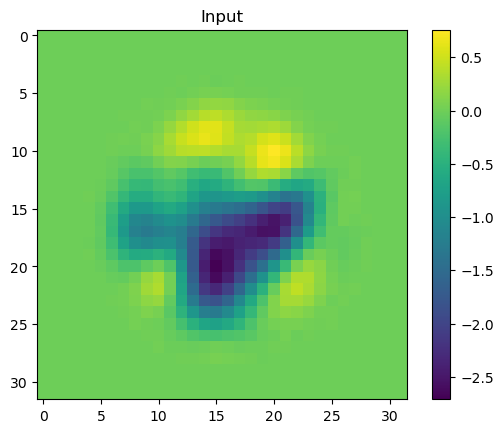

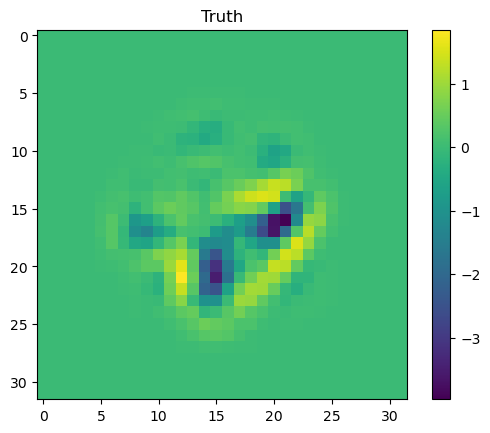

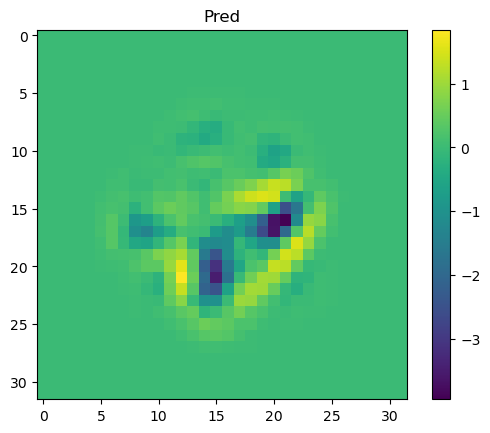

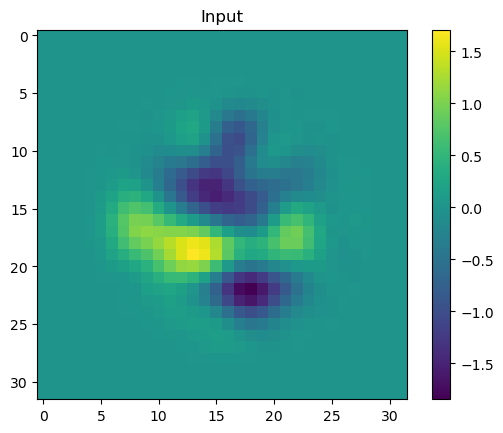

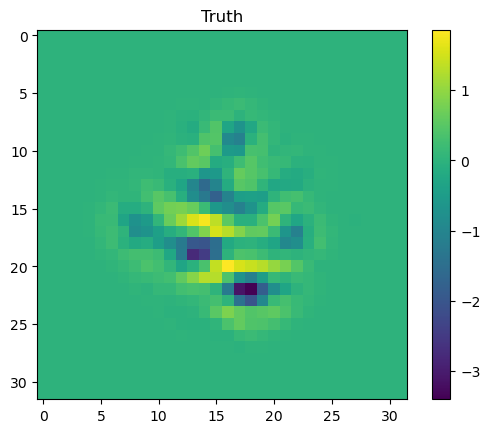

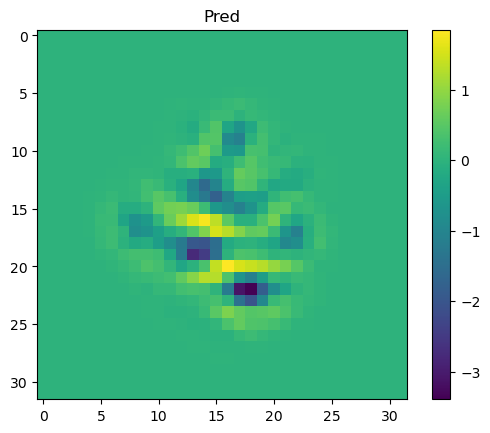

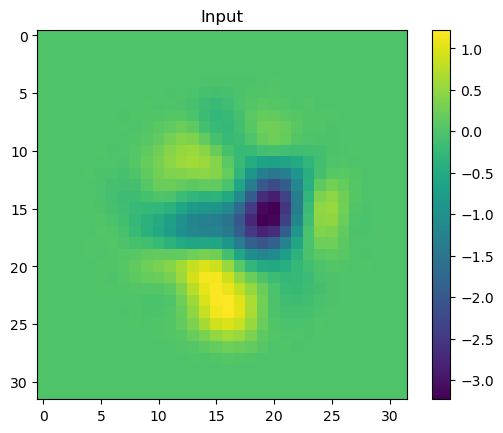

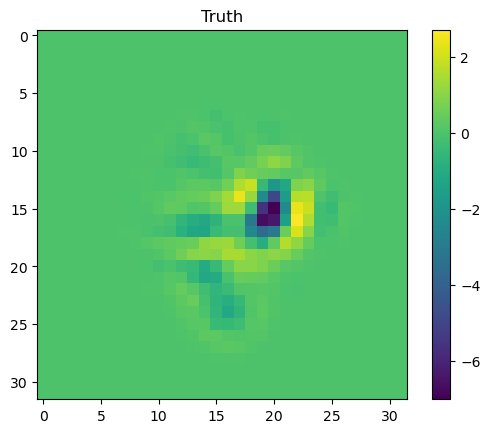

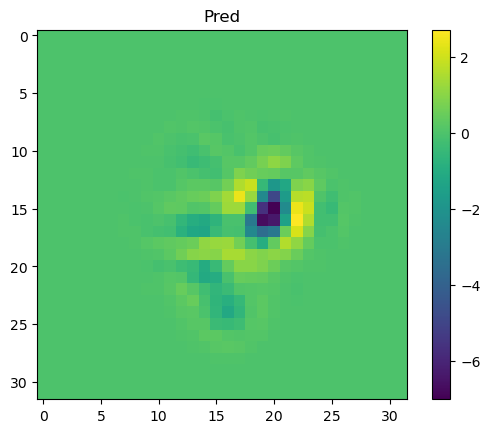

POU_net(
  (gating_net): FieldGatingNet(
    (_gating_net): LightningSequential(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
          (1): SiLU()
        )
        (1-2): 2 x Sequential(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
          (1): SiLU()
        )
        (3): Sequential(
          (0): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1), padding=same)
          (1): Identity()
        )
      )
    )
  )
  (experts): ModuleList(
    (0-1): 2 x MOR_Operator(
      (layers): ModuleList(
        (0): MOR_Layer(
          (h_mlp): LightningSequential(
            (layers): ModuleList(
              (0): Sequential(
                (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
                (1): SiLU()
              )
              (1): Sequential(
                (0): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
   

In [44]:
# This display loop, Verified to work 7/19/24
shuffle_loader = torch.utils.data.DataLoader(dataset, shuffle=True)
model = model.cuda()
model.eval()

for i, datum in enumerate(shuffle_loader):
    if i>10: break
    X, y = datum
    plt.figure(1+i*3)
    plt.imshow(X.squeeze())
    plt.colorbar()
    plt.title('Input')
    
    plt.figure(2+i*3)
    plt.imshow(y.squeeze())
    plt.colorbar()
    plt.title('Truth')
    
    plt.figure(3+i*3)
    plt.imshow(model(X.to(model.device)).cpu().detach().squeeze())
    plt.colorbar()
    plt.title('Pred')
    plt.show()
model.train()